In [144]:
"""Plotting parameters"""
from matplotlib import rcParams
#rcParams['axes.formatter.limits'] = (-7, 7)
rcParams['axes.formatter.limits'] = (-2,3)
rcParams['axes.labelsize'] = 22
rcParams['xtick.labelsize'] = 22
rcParams['ytick.labelsize'] = 22
rcParams['font.size'] = 22

In [136]:
"""Import packages"""
import datetime
import xarray as xr
import numpy as np
import matplotlib.pyplot as pl
import scipy.io as sio
%matplotlib inline

In [137]:
"""Get openDAP URLs and download data"""
url1='http://tds.marine.rutgers.edu/thredds/dodsC/roms/ecb/del/2007-2008/avg'
url2='http://tds.marine.rutgers.edu/thredds/dodsC/roms/ecb/del/2009-2011/avg'
ds1 = xr.open_dataset(url1)
ds2 = xr.open_dataset(url2)

# slicing throught the time, xi_u and eta_u dimensions
Hvom1 = ds1.sel(ocean_time=slice('2007','2008'),eta_v=126,xi_v=slice(25, 54)).Hvom
Hvom_slbDOC1 =ds1.sel(ocean_time=slice('2007','2008'),eta_v=126,xi_v=slice(25, 54)).Hvom_semilabileDOC
Hvom_rfrDOC1 =ds1.sel(ocean_time=slice('2007','2008'),eta_v=126,xi_v=slice(25, 54)).Hvom_refractoryDOC
#
Hvom2 = ds2.sel(ocean_time=slice('2009','2011'),eta_v=126,xi_v=slice(25, 54)).Hvom
Hvom_slbDOC2 =ds2.sel(ocean_time=slice('2009','2011'),eta_v=126,xi_v=slice(25, 54)).Hvom_semilabileDOC
Hvom_rfrDOC2 =ds2.sel(ocean_time=slice('2009','2011'),eta_v=126,xi_v=slice(25, 54)).Hvom_refractoryDOC

In [138]:
Hvom.shape

(1824, 20, 29)

In [141]:
# concatenate arrays
Hvom_DOC1=Hvom_slbDOC1 + Hvom_rfrDOC1
Hvom_DOC2=Hvom_slbDOC2 + Hvom_rfrDOC2
Hvom = xr.concat([Hvom1, Hvom2], dim='ocean_time')
Hvom_DOC = xr.concat([Hvom_DOC1, Hvom_DOC2], dim='ocean_time')

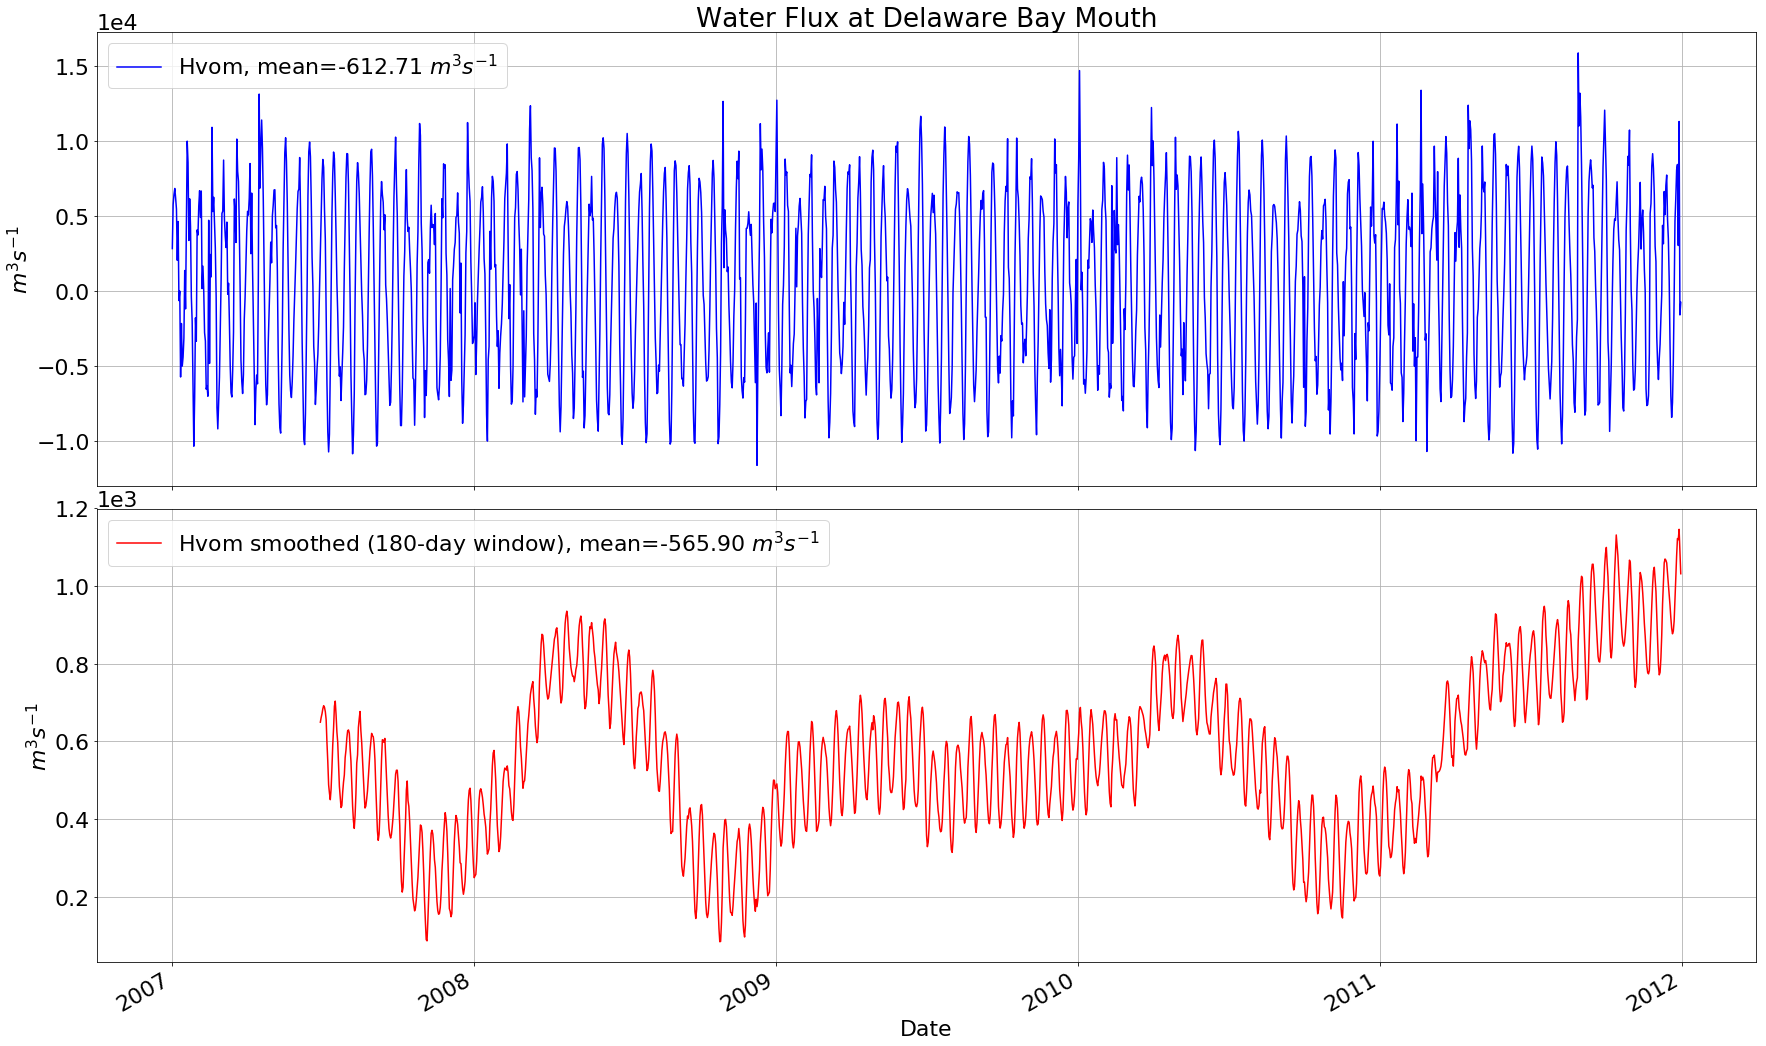

In [145]:
# sum over 2nd axis then sum over first axis
# Chenged Hvom sign - positive is now out
sum_Hvom = Hvom.sum(axis=2).sum(axis=1)

#rolling mean:
window = 180
sm=sum_Hvom.rolling(ocean_time=window).mean()

# to get the dimension names
Hvom.dims

# summing over dimensions
sum_Hvom2 = Hvom.sum(dim=['s_rho', 'xi_v'])

# plotting time series
# raw time series
#sum_Huon.plot.line(ax=ax);
# smoothed time series (10day rolling window)
#sm.plot.line(ax=ax, color='r')

f, ax = pl.subplots(nrows=2, sharex=True, figsize=(25, 15))
# Daily Hvom
yplt1 = -sum_Hvom.sel(ocean_time=slice('2007','2011'))
yplt1.plot.line( 'b-', label=f'Hvom, mean={float(sum_Hvom.mean()): .2f}' + \
        ' $m^3 s^{-1}$', ax=ax[0])
ax[0].set_ylabel('$m^3 s^{-1}$')
ax[0].legend()
ax[0].set_title('Water Flux at Delaware Bay Mouth')
ax[0].grid()
# smoothed Hvom
yplt2 = -sm.sel(ocean_time=slice('2007','2011'))
yplt2.plot.line('r-', label=f'Hvom smoothed ({window}-day window), \
mean={float(sm.mean()): .2f}' + ' $m^3 s^{-1}$', ax=ax[1])
ax[1].set_ylabel('$m^3 s^{-1}$')
ax[1].set_xlabel('Date')
ax[1].legend();
ax[1].grid()
f.tight_layout(h_pad=0.01)

# assert equality of two data arrays
xr.testing.assert_equal(sum_Hvom,sum_Hvom2)

f.savefig('Figures/Hvom_DBM.png',dpi=300)

In [146]:
"""Get the mean Huon in m3/s - negativeive is seaward"""
np.mean(sum_Hvom)

<xarray.DataArray 'Hvom' ()>
array(-612.7138992443045)

In [147]:
sum_Hvom_DOC = Hvom_DOC.sum(dim=['s_rho', 'xi_v'])
"""m3/s x mmol-C/m3 to Tg-C/yr"""
sum_Hvom_DOC = sum_Hvom_DOC*12*1e-3*86400*365*1e-12

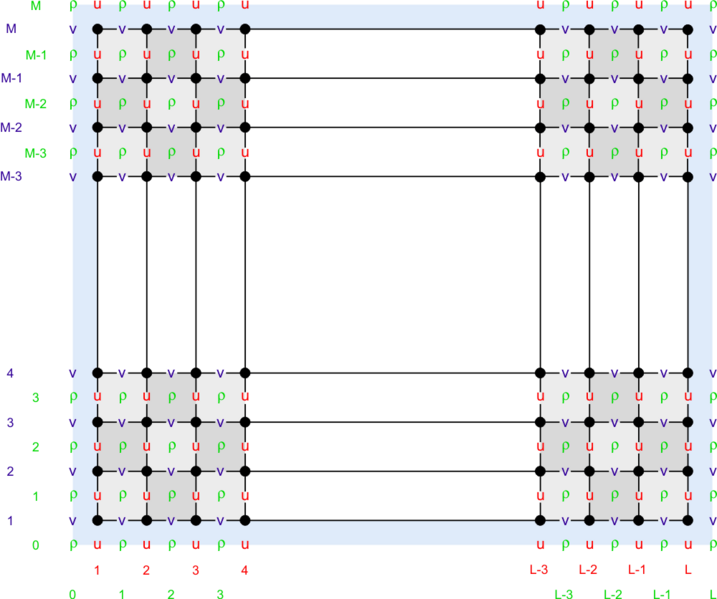

In [148]:
# Horizontal discretization of grid cells - significant for Hvom*DOC calculation 
from IPython.display import Image
Image(filename='Figures/717px-staggered_grid_rho_cells.png')

In [149]:
"""Daily Huon*DOC - Following Aboozar's suggestion, as Pierre did:
tracers (e.g DOC, salt) are calculated at the middle of each cell but
velocities are calculated at the sides, so the right way to calculate
uhvom x DOC would be to average DOC at 2 center points before and after
the side. I took cell j=126 for tracers and so I'm averaging DOC in the
center of cell 125 and 126 """
# 2007-2008 run
DOCslb1 =ds1.sel(ocean_time=slice('2007','2008'),eta_rho=125,xi_rho=slice(25, 54)).semilabileDOC
DOCslb2 =ds1.sel(ocean_time=slice('2007','2008'),eta_rho=126,xi_rho=slice(25, 54)).semilabileDOC
DOCrfr1 =ds1.sel(ocean_time=slice('2007','2008'),eta_rho=125,xi_rho=slice(25, 54)).refractoryDOC
DOCrfr2 =ds1.sel(ocean_time=slice('2007','2008'),eta_rho=126,xi_rho=slice(25, 54)).refractoryDOC
wrk1 = 0.5*(DOCslb1 + DOCslb2)
wrk2 = 0.5*(DOCrfr1 + DOCrfr2)
DOC1 = wrk1 + wrk2
# 2009-2011 run
DOCslb3 =ds2.sel(ocean_time=slice('2009','2011'),eta_rho=125,xi_rho=slice(25, 54)).semilabileDOC
DOCslb4 =ds2.sel(ocean_time=slice('2009','2011'),eta_rho=126,xi_rho=slice(25, 54)).semilabileDOC
DOCrfr3 =ds2.sel(ocean_time=slice('2009','2011'),eta_rho=125,xi_rho=slice(25, 54)).refractoryDOC
DOCrfr4 =ds2.sel(ocean_time=slice('2009','2011'),eta_rho=126,xi_rho=slice(25, 54)).refractoryDOC
wrk3 = 0.5*(DOCslb3 + DOCslb4)
wrk4 = 0.5*(DOCrfr3 + DOCrfr4)
DOC2 = wrk3 + wrk4
# concatenate arrays
DOC = xr.concat([DOC1, DOC2], dim='ocean_time')

In [150]:
# compute Hvom*DOC
HvomDOC=np.multiply(Hvom, DOC)
sum_HvomDOC = HvomDOC.sum(dim=['s_rho', 'xi_v'])
"""m3/s x mmol-C/m3 to Tg-C/yr"""
sum_HvomDOC = sum_HvomDOC*12*1e-3*86400*365*1e-12
# apply rolling filter
sm_HvomDOC=sum_HvomDOC.rolling(ocean_time=window).mean()

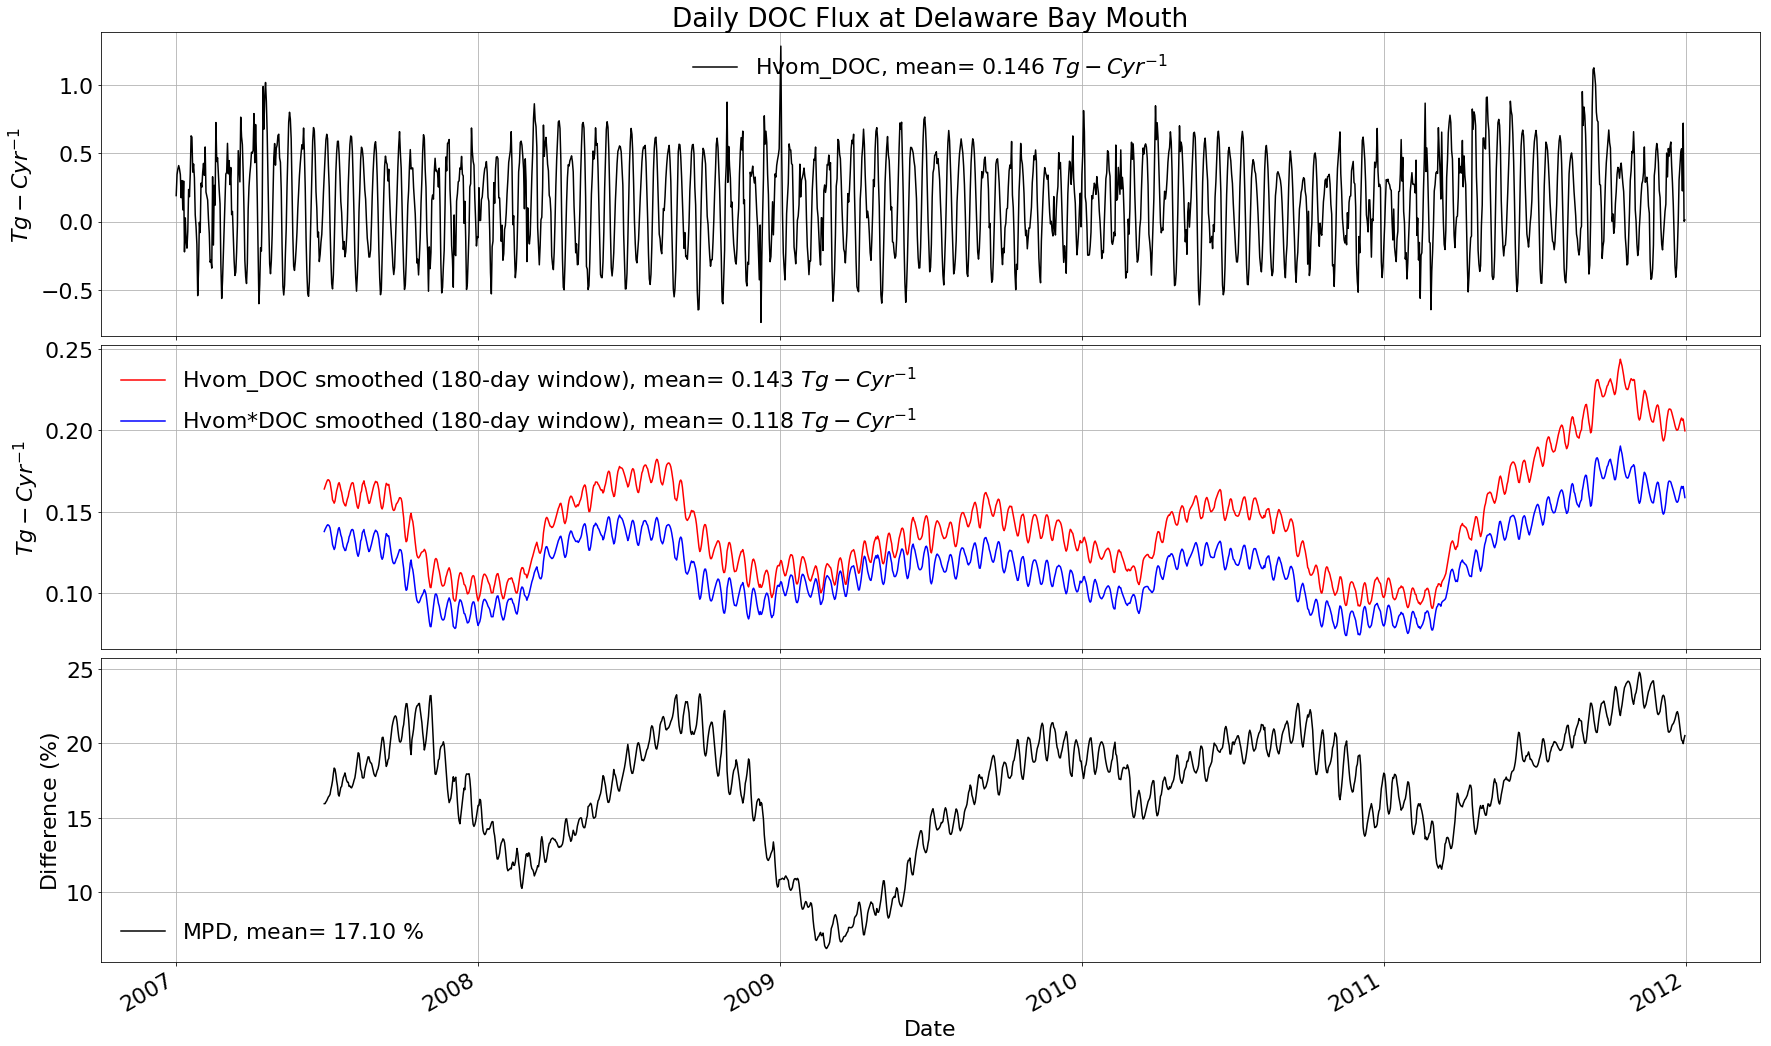

In [152]:
# plotting time series of DOC flux calculated using the two different methods
sm=sum_Hvom_DOC.rolling(ocean_time=window).mean()
# mean percent difference between the two methods
MPD = 100*(sm - sm_HvomDOC)/sm
#MPD = MPD.mean(dim=['ocean_time'])
f, ax = pl.subplots(nrows=3, sharex=True, figsize=(25, 15))
# Daily DOC Flux
yplot1 = -sum_Hvom_DOC.sel(ocean_time=slice('2007','2011'))
yplot1.plot.line( 'k-',
    label=f'Hvom_DOC, mean={float(yplot1.mean()): .3f}' + ' $Tg-C yr^{-1}$', ax=ax[0])
ax[0].set_ylabel('$Tg-C yr^{-1}$')
ax[0].legend(frameon=False)
ax[0].set_title('Daily DOC Flux at Delaware Bay Mouth')
ax[0].grid()
# DOC flux smoothed with rolling mean filter
yplot2 = -sm.sel(ocean_time=slice('2007','2011'))
yplot2.plot.line('r-',
    label=f'Hvom_DOC smoothed ({window}-day window), mean={float(yplot2.mean()): .3f}' +
    ' $Tg-C yr^{-1}$', ax=ax[1])
ax[1].set_ylabel('$Tg-C yr^{-1}$')
ax[1].legend(frameon=False);
yplot3 = -sm_HvomDOC.sel(ocean_time=slice('2007','2011'))
yplot3.plot.line('b-',
    label=f'Hvom*DOC smoothed ({window}-day window), mean={float(yplot3.mean()): .3f}' +
    ' $Tg-C yr^{-1}$', ax=ax[1])
ax[1].set_ylabel('$Tg-C yr^{-1}$')
ax[1].legend(frameon=False)
ax[1].grid()
# MPD
yplot4 = MPD.sel(ocean_time=slice('2007','2011'))
yplot4.plot.line('k-',
    label=f'MPD, mean={float(MPD.mean()): .2f}' + ' $\%$', ax=ax[2])
ax[2].set_ylabel('Difference ($\%$)')
ax[2].set_xlabel('Date')
ax[2].legend(frameon=False)
ax[2].grid()
# Export figure
f.tight_layout(h_pad=0.01)
f.savefig('Figures/Hvom_DOCflux_DBM.png',dpi=300)

In [153]:
mean_DOC = DOC.mean(dim=['s_rho', 'xi_rho'])

In [154]:
mean_DOC.shape

(1824,)

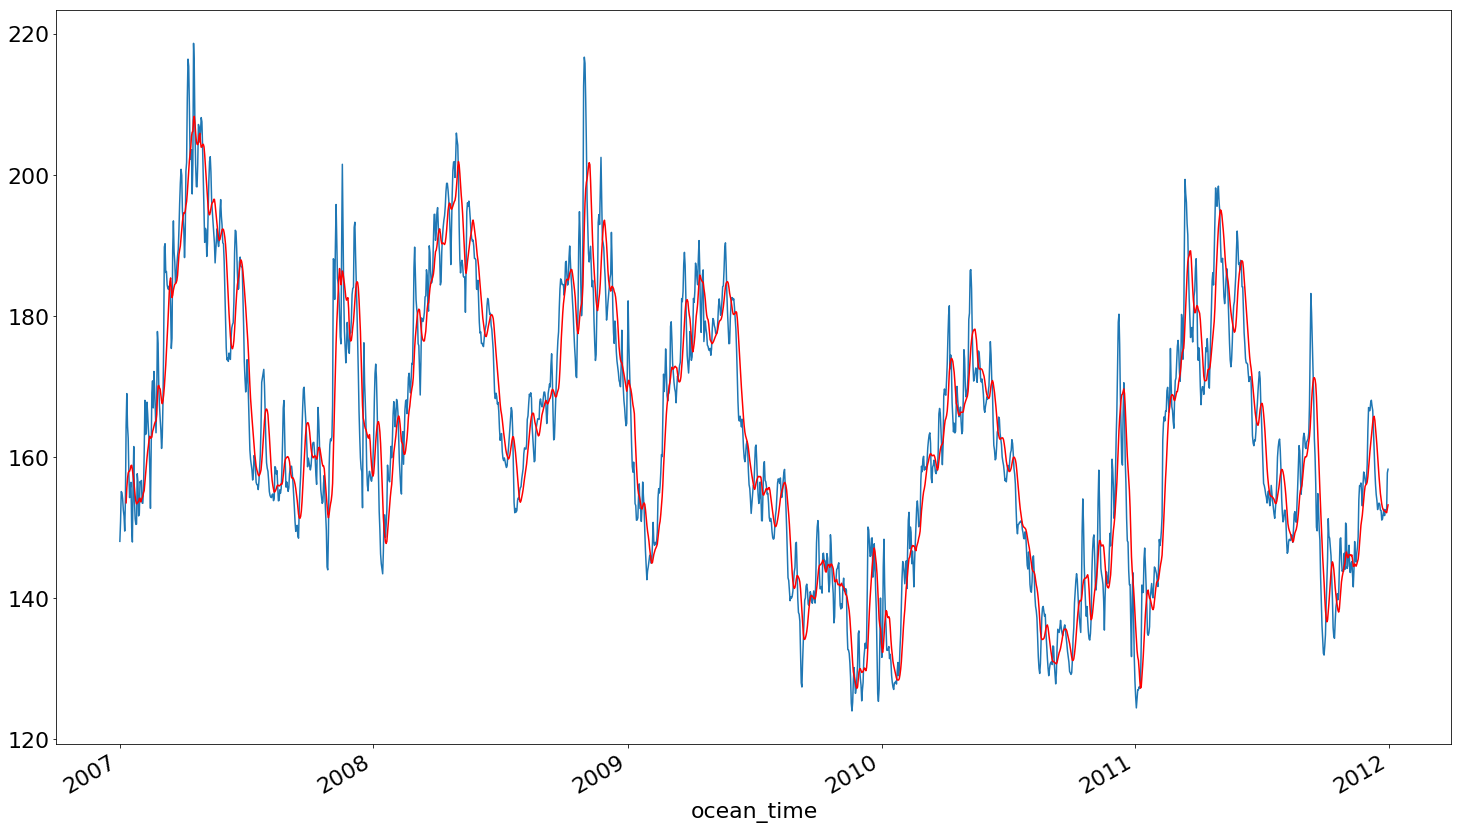

In [155]:
# plotting time series
f, ax=pl.subplots(figsize=(25, 15))
# raw time series
mean_DOC.plot.line(ax=ax);
#rolling mean:
sm=mean_DOC.rolling(ocean_time=10).mean()
# smoothed time series (10day rolling window)
sm.plot.line(ax=ax, color='r')

In [87]:
# make a data set array for storage
data_array_list = Hvom, DOC, Hvom_DOC, HvomDOC
def make_dataset(*data_array_list):
    xr_ds = xr.Dataset({data_array.name: data_array for
data_array in data_array_list 
                        })
    return xr_ds
ds = make_dataset(Hvom, DOC, Hvom_DOC, HvomDOC)
# We can save a Dataset to disk using the Dataset.to_netcdf method:
ds.to_netcdf('data/db_roms_docflux.nc')